Интернет-магазин «Викишоп» запускает новый сервис, благодаря которому пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Мне необходимо обучить модель классифицировать комментарии на позитивные и негативные. В моём распоряжении набор данных с разметкой о токсичности правок.


# 1. Подготовка

##### 1.1. Загрузка библиотек и получение информации о датафрейме 

In [1]:
#Загрузим необходимые библиотеки
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from scipy import stats as st
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, make_scorer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from IPython.display import display
from lightgbm import LGBMClassifier
import re
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ksenydelik\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ksenydelik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
data = pd.read_csv('comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


<strong>Вывод:</strong>В данных нет пропусков, типы данных правильные.

##### 1.2.Проверка дисбаланса клаасов 

0    0.898321
1    0.101679
Name: toxic, dtype: float64


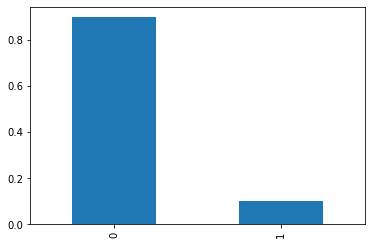

In [5]:
class_frequency = data['toxic'].value_counts(normalize=bool)
print(class_frequency)
class_frequency.plot(kind='bar')

<strong>Вывод:</strong>В данном датасете мы наблюдаем сильный дисбаланс классов


##### 1.3. Лемматизация текстов пр ипомощи WordNet NLTK 

In [6]:
#создадим функцию для лемматизации
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [7]:
def clear_text(text):
    ex1 = re.sub(r'[^a-zA-Z ]', ' ', text)
    ex = " ".join(ex1.split())
    return ex

In [8]:
%%time
#применим функцию ко всему датафрейму
data['lemm_text'] = data['text'].apply(
     lambda x: lemmatize(clear_text(x))
)

Wall time: 1min 28s


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       159571 non-null  object
 1   toxic      159571 non-null  int64 
 2   lemm_text  159571 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.7+ MB


# 2. Обучение

##### 2.1Создадим обучающую и тестовую выборки

In [10]:
data_train, data_test = train_test_split(data, test_size=0.1, random_state=12345)

##### 2.2. Текст трансофрмер

In [11]:
corpus = data_train['lemm_text']

nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords, max_features=150000)
tf_idf = count_tf_idf.fit_transform(corpus)

print("Размер матрицы:", tf_idf.shape)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ksenydelik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер матрицы: (143613, 150000)


In [12]:
corpus_test = data_test['lemm_text']

count_tf_idf_test = TfidfVectorizer(stop_words=stopwords)
tf_idf_test = count_tf_idf.transform(corpus_test)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (15958, 150000)


In [13]:
target_train = data_train['toxic']
target_test = data_test['toxic']

##### 2.3. Модель Логистической регрессии

In [14]:
f1 = make_scorer(f1_score , average='macro')

In [15]:
model_linear=LogisticRegression()
param_grid = { 
    'class_weight': ['balanced', None],
    }

In [16]:
%%time
CV_lr = GridSearchCV(estimator=model_linear, param_grid=param_grid, n_jobs= -1, cv = 3, scoring=f1)
CV_lr.fit(tf_idf, target_train)
CV_lr.best_params_

Wall time: 20.2 s


{'class_weight': 'balanced'}

In [17]:
%%time
model = LogisticRegression(random_state=12345, class_weight='balanced') 
model.fit(tf_idf, target_train)
predicted_test = model.predict(tf_idf_test)
result = f1_score(target_test, predicted_test)
print("f1-мера логистической регрессии:", '{:.2f}'.format(result))

f1-мера логистической регрессии: 0.75
Wall time: 5.14 s


##### 2.3. Модель Случайного леса

In [18]:
model_forest = RandomForestClassifier(random_state=0)
param_grid = { 
    'max_depth' : [15,20],
    'class_weight' : ['balanced'],
    'n_estimators' : [150]
    }

In [19]:
%%time
CV_fc = GridSearchCV(estimator=model_forest, param_grid=param_grid,  n_jobs= -1, cv = 3, scoring=f1)
CV_fc.fit(tf_idf, target_train)
CV_fc.best_params_

Wall time: 3min 8s


{'class_weight': 'balanced', 'max_depth': 20, 'n_estimators': 150}

In [20]:
%%time
model_forest = RandomForestClassifier(random_state=12345, n_estimators=150, max_depth=20, class_weight='balanced') 
model_forest.fit(tf_idf, target_train)
predicted_forest_test = model_forest.predict(tf_idf_test)
result_forest = f1_score(target_test, predicted_forest_test)
print("f1-мера случайного леса:", '{:.2f}'.format(result_forest))

f1-мера случайного леса: 0.41
Wall time: 20.9 s


##### 2.4. Модель Решающего дерева

In [21]:
model_tree = DecisionTreeClassifier(random_state=0)
param_grid = { 
    'max_depth' : [10,15,20],
    }

In [22]:
%%time
CV_tc = GridSearchCV(estimator=model_tree, param_grid=param_grid,  n_jobs= -1, cv = 3, scoring=f1)
CV_tc.fit(tf_idf, target_train)
CV_tc.best_params_

Wall time: 1min 14s


{'max_depth': 20}

In [23]:
%%time
model_tree = DecisionTreeClassifier(random_state=12345, max_depth=20, class_weight='balanced')
model_tree.fit(tf_idf, target_train)
predicted_tree_test = model_tree.predict(tf_idf_test)
result_tree = f1_score(target_test, predicted_tree_test)
print("f1-мера дерева решений:", '{:.2f}'.format(result_tree))

f1-мера дерева решений: 0.60
Wall time: 21.8 s


##### 2.5. Модель Градиентного бустинга

In [25]:
%%time
model_LGBM = LGBMClassifier(class_weight='balanced', n_estimators=150, max_depth=20, num_leaves=100)
model_LGBM.fit(tf_idf, target_train)
predicted_LGBM_test = model_LGBM.predict(tf_idf_test)
result_LGBM = f1_score(target_test, predicted_LGBM_test)
print("f1-мера дерева решений:", '{:.2f}'.format(result_LGBM))

f1-мера дерева решений: 0.74
Wall time: 38.4 s


# 3. Выводы

В данном проекте мы построили модели для поиска токсичных комментариев. Тектовые данные были лемматизированы, а также была дана оценка важности слов при помощи TD_IDF. Лучшей моделью является модель логистической регресиии. F1-мера этой модели равна 0,75. Плюсом данной модели также является скорость её работы. Остальные модели показали более низкую f1 меру и работают гораздо дольше. 